<a href="https://colab.research.google.com/github/kumar045/Assignment-For-Filed/blob/main/machine_translation_v2_yt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1
- Overview
- Demo
- Model overview
- Preloaded model & tokenizer
- Quick test

## Part 2
- Update model
- Load dataset
- Data formatting loader

## Part 3
- Training
- Testing
- Recreate demo

# Download Modules

In [ ]:
!pip install transformers sentencepiece datasets

In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook

sns.set()

In [ ]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Use 'google/mt5-small' for non-pro cloab users
model_repo = 'google/mt5-base'
model_path = '/content/gdrive/My Drive/mt5_translation.pt'
max_seq_len = 20

# Load Tokenizer & Model

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

In [ ]:
# Model description: https://huggingface.co/google/mt5-base
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

NameError: ignored

# Overview and Quick Test

In [ ]:
token_ids = tokenizer.encode(
    '<jp> This will be translated to Japanese! (hopefully)',
    return_tensors='pt').cuda()
print(token_ids)

model_out = model.generate(token_ids)
print(model_out)

output_text = tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(model_out[0]))
print(output_text)

tensor([[  1042,   3889,    669,   1494,    898,    390,  37194,    285,    288,
          30865,    309,    274, 116024,  11994,    271,      1]],
       device='cuda:0')
tensor([[     0, 250099,    259,    264,    259, 228700,      1]],
       device='cuda:0')
<pad> <extra_id_0> - issuu</s>


# Steps
1. Load the pretrained model and tokenizer
2. Load dataset
3. Transform dataset into input (entails a minor model change)
4. Train/finetune the model on our dataset
5. Test the model

# Test Tokenizer

In [ ]:
example_input_str = '<jp> This is just a test nbuig.'
# example_input_str = 'これは普通のテスト'
input_ids = tokenizer.encode(example_input_str, return_tensors='pt')
print('Input IDs:', input_ids)

tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
print('Tokens:', tokens)

Input IDs: tensor([[1042, 3889,  669, 1494,  339, 1627,  259,  262, 2978,  259,  272, 1982,
         1315,  260,    1]])
Tokens: ['▁<', 'jp', '>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>']


In [ ]:
sorted(tokenizer.vocab.items(), key=lambda x: x[1])

# Prepare Dataset

In [ ]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset('alt')

No config specified, defaulting to: alt/alt-parallel
Reusing dataset alt (/root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/70124cadb11e926eb17904d6edf5f79041aee772bab75a7ef37cb25633fed98f)


In [ ]:
train_dataset = dataset['train']
test_dataset = dataset['test']

In [ ]:
train_dataset[0]

{'SNT.URLID': '80188',
 'SNT.URLID.SNTID': '1',
 'translation': {'bg': 'ফ্রান্সের প্যারিসের পার্ক দি প্রিন্সেস-এ হওয়া ২০০৭-এর রাগবি বিশ্বকাপের পুল সি-তে ইটালি পর্তুগালকে ৩১-৫ গোলে হারিয়েছে।',
  'en': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes, Paris, France.',
  'en_tok': 'Italy have defeated Portugal 31-5 in Pool C of the 2007 Rugby World Cup at Parc des Princes , Paris , France .',
  'fil': 'Natalo ng Italya ang Portugal sa puntos na 31-5 sa Grupong C noong 2007 sa Pandaigdigang laro ng Ragbi sa Parc des Princes, Paris, France.',
  'hi': '2007 में फ़्रांस, पेरिस के पार्क डेस प्रिंसेस में हुए रग्बी विश्व कप के पूल C में इटली ने पुर्तगाल को 31-5 से हराया।',
  'id': 'Italia berhasil mengalahkan Portugal 31-5 di grup C dalam Piala Dunia Rugby 2007 di Parc des Princes, Paris, Perancis.',
  'ja': 'フランスのパリ、パルク・デ・プランスで行われた2007年ラグビーワールドカップのプールCで、イタリアは31対5でポルトガルを下した。',
  'khm': 'អ៊ីតាលីបានឈ្នះលើព័រទុយហ្គាល់ 31-5 ក្នុងប៉ូលCនៃពីធីប្រកួតពានរង្វាន់

In [ ]:
LANG_TOKEN_MAPPING = {
    'en': '<en>',
    'ja': '<jp>',
    'zh': '<zh>'
}

In [ ]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
tokenizer.add_special_tokens(special_tokens_dict)
model.resize_token_embeddings(len(tokenizer))

Embedding(250103, 768)

In [ ]:
token_ids = tokenizer.encode(
    example_input_str, return_tensors='pt', padding='max_length',
    truncation=True, max_length=max_seq_len)
print(token_ids)

tokens = tokenizer.convert_ids_to_tokens(token_ids[0])
print(tokens)

tensor([[250101,   1494,    339,   1627,    259,    262,   2978,    259,    272,
           1982,   1315,    260,      1,      0,      0,      0,      0,      0,
              0,      0]])
['<jp>', '▁This', '▁is', '▁just', '▁', 'a', '▁test', '▁', 'n', 'bu', 'ig', '.', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
def encode_input_str(text, target_lang, tokenizer, seq_len,
                     lang_token_map=LANG_TOKEN_MAPPING):
  target_lang_token = lang_token_map[target_lang]

  # Tokenize and add special tokens
  input_ids = tokenizer.encode(
      text = target_lang_token + text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return input_ids[0]

def encode_target_str(text, tokenizer, seq_len,
                      lang_token_map=LANG_TOKEN_MAPPING):
  token_ids = tokenizer.encode(
      text = text,
      return_tensors = 'pt',
      padding = 'max_length',
      truncation = True,
      max_length = seq_len)

  return token_ids[0]

def format_translation_data(translations, lang_token_map,
                            tokenizer, seq_len=128):
  # Choose a random 2 languages for in i/o
  langs = list(lang_token_map.keys())
  input_lang, target_lang = np.random.choice(langs, size=2, replace=False)

  # Get the translations for the batch
  input_text = translations[input_lang]
  target_text = translations[target_lang]

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_input_str(
      input_text, target_lang, tokenizer, seq_len, lang_token_map)

  target_token_ids = encode_target_str(
      target_text, tokenizer, seq_len, lang_token_map)

  return input_token_ids, target_token_ids

def transform_batch(batch, lang_token_map, tokenizer):
  inputs = []
  targets = []
  for translation_set in batch['translation']:
    formatted_data = format_translation_data(
        translation_set, lang_token_map, tokenizer, max_seq_len)

    if formatted_data is None:
      continue

    input_ids, target_ids = formatted_data
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))

  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

def get_data_generator(dataset, lang_token_map, tokenizer, batch_size=32):
  dataset = dataset.shuffle()
  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield transform_batch(raw_batch, lang_token_map, tokenizer)

In [ ]:
# Testing `data_transform`
in_ids, out_ids = format_translation_data(
    train_dataset[0]['translation'], LANG_TOKEN_MAPPING, tokenizer)

print(' '.join(tokenizer.convert_ids_to_tokens(in_ids)))
print(' '.join(tokenizer.convert_ids_to_tokens(out_ids)))

# Testing data generator
data_gen = get_data_generator(train_dataset, LANG_TOKEN_MAPPING, tokenizer, 8)
data_batch = next(data_gen)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)

<zh> ▁Italy ▁have ▁de feat ed ▁Portugal ▁3 1-5 ▁in ▁Pool ▁C ▁of ▁the ▁2007 ▁ Rugby ▁World ▁Cup ▁at ▁Parc ▁des ▁Princes , ▁Paris , ▁France . </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
▁ 意大利 在 法国 巴黎 王子 公园 体育 场 举办 的 2007 年 橄 榄 球 世界杯 C 组 以 3 1-5 击 败 葡萄 牙 。 </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> 

Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/alt/alt-parallel/1.0.0/70124cadb11e926eb17904d6edf5f79041aee772bab75a7ef37cb25633fed98f/cache-3f2f82a4f39ef8f1.arrow


Input shape: torch.Size([8, 20])
Output shape: torch.Size([8, 20])


# Train/Finetune BERT

In [ ]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [ ]:
# Constants
n_epochs = 8
batch_size = 16
print_freq = 50
checkpoint_freq = 1000
lr = 5e-4
n_batches = int(np.ceil(len(train_dataset) / batch_size))
total_steps = n_epochs * n_batches
n_warmup_steps = int(total_steps * 0.01)

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

In [ ]:
losses = []

In [ ]:
def eval_model(model, gdataset, max_iters=8):
  test_generator = get_data_generator(gdataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())

  return np.mean(eval_losses)

In [ ]:
for epoch_idx in range(n_epochs):
  # Randomize data order
  data_generator = get_data_generator(train_dataset, LANG_TOKEN_MAPPING,
                                      tokenizer, batch_size)

  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss and update weights
    loss = model_out.loss
    losses.append(loss.item())
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Print training update info
    if (batch_idx + 1) % print_freq == 0:
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, test_dataset)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Epoch: 1 | Step: 50 | Avg. loss: 2.017 | lr: 0.0003060392944853762
Epoch: 1 | Step: 100 | Avg. loss: 2.022 | lr: 0.00030324849296718015
Epoch: 1 | Step: 150 | Avg. loss: 2.073 | lr: 0.0003004576914489842
Epoch: 1 | Step: 200 | Avg. loss: 2.025 | lr: 0.0002976668899307881
Epoch: 1 | Step: 250 | Avg. loss: 2.012 | lr: 0.0002948760884125921
Epoch: 1 | Step: 300 | Avg. loss: 2.066 | lr: 0.0002920852868943961
Epoch: 1 | Step: 350 | Avg. loss: 2.069 | lr: 0.00028929448537620006
Epoch: 1 | Step: 400 | Avg. loss: 2.087 | lr: 0.00028650368385800404
Epoch: 1 | Step: 450 | Avg. loss: 2.055 | lr: 0.000283712882339808
Epoch: 1 | Step: 500 | Avg. loss: 2.060 | lr: 0.00028092208082161195
Epoch: 1 | Step: 550 | Avg. loss: 2.088 | lr: 0.000278131279303416
Epoch: 1 | Step: 600 | Avg. loss: 2.095 | lr: 0.0002753404777852199
Epoch: 1 | Step: 650 | Avg. loss: 2.046 | lr: 0.00027254967626702385
Epoch: 1 | Step: 700 | Avg. loss: 2.117 | lr: 0.0002697588747488279
Epoch: 1 | Step: 750 | Avg. loss: 2.067 | lr: 

Epoch: 2 | Step: 50 | Avg. loss: 1.874 | lr: 0.00024291136414378208
Epoch: 2 | Step: 100 | Avg. loss: 1.892 | lr: 0.00024012056262558607
Epoch: 2 | Step: 150 | Avg. loss: 1.883 | lr: 0.00023732976110739005
Epoch: 2 | Step: 200 | Avg. loss: 1.863 | lr: 0.00023453895958919403
Epoch: 2 | Step: 250 | Avg. loss: 1.917 | lr: 0.000231748158070998
Epoch: 2 | Step: 300 | Avg. loss: 1.878 | lr: 0.00022895735655280197
Epoch: 2 | Step: 350 | Avg. loss: 1.908 | lr: 0.00022616655503460595
Epoch: 2 | Step: 400 | Avg. loss: 1.882 | lr: 0.00022337575351640993
Epoch: 2 | Step: 450 | Avg. loss: 1.813 | lr: 0.0002205849519982139
Epoch: 2 | Step: 500 | Avg. loss: 1.961 | lr: 0.00021779415048001785
Epoch: 2 | Step: 550 | Avg. loss: 1.819 | lr: 0.00021500334896182183
Epoch: 2 | Step: 600 | Avg. loss: 1.885 | lr: 0.0002122125474436258
Epoch: 2 | Step: 650 | Avg. loss: 1.813 | lr: 0.0002094217459254298
Epoch: 2 | Step: 700 | Avg. loss: 1.815 | lr: 0.00020663094440723375
Epoch: 2 | Step: 750 | Avg. loss: 1.861 

Epoch: 3 | Step: 50 | Avg. loss: 1.627 | lr: 0.00017978343380218797
Epoch: 3 | Step: 100 | Avg. loss: 1.748 | lr: 0.00017699263228399196
Epoch: 3 | Step: 150 | Avg. loss: 1.715 | lr: 0.00017420183076579594
Epoch: 3 | Step: 200 | Avg. loss: 1.739 | lr: 0.0001714110292475999
Epoch: 3 | Step: 250 | Avg. loss: 1.648 | lr: 0.00016862022772940388
Epoch: 3 | Step: 300 | Avg. loss: 1.733 | lr: 0.00016582942621120786
Epoch: 3 | Step: 350 | Avg. loss: 1.702 | lr: 0.00016303862469301184
Epoch: 3 | Step: 400 | Avg. loss: 1.734 | lr: 0.00016024782317481583
Epoch: 3 | Step: 450 | Avg. loss: 1.691 | lr: 0.00015745702165661978
Epoch: 3 | Step: 500 | Avg. loss: 1.766 | lr: 0.00015466622013842377
Epoch: 3 | Step: 550 | Avg. loss: 1.719 | lr: 0.00015187541862022775
Epoch: 3 | Step: 600 | Avg. loss: 1.705 | lr: 0.0001490846171020317
Epoch: 3 | Step: 650 | Avg. loss: 1.681 | lr: 0.00014629381558383566
Epoch: 3 | Step: 700 | Avg. loss: 1.756 | lr: 0.00014350301406563964
Epoch: 3 | Step: 750 | Avg. loss: 1.7

Epoch: 4 | Step: 50 | Avg. loss: 1.526 | lr: 0.00011665550346059388
Epoch: 4 | Step: 100 | Avg. loss: 1.610 | lr: 0.00011386470194239785
Epoch: 4 | Step: 150 | Avg. loss: 1.575 | lr: 0.00011107390042420183
Epoch: 4 | Step: 200 | Avg. loss: 1.557 | lr: 0.00010828309890600582
Epoch: 4 | Step: 250 | Avg. loss: 1.622 | lr: 0.00010549229738780978
Epoch: 4 | Step: 300 | Avg. loss: 1.555 | lr: 0.00010270149586961377
Epoch: 4 | Step: 350 | Avg. loss: 1.618 | lr: 9.991069435141772e-05
Epoch: 4 | Step: 400 | Avg. loss: 1.586 | lr: 9.71198928332217e-05
Epoch: 4 | Step: 450 | Avg. loss: 1.589 | lr: 9.432909131502567e-05
Epoch: 4 | Step: 500 | Avg. loss: 1.558 | lr: 9.153828979682966e-05
Epoch: 4 | Step: 550 | Avg. loss: 1.579 | lr: 8.874748827863363e-05
Epoch: 4 | Step: 600 | Avg. loss: 1.559 | lr: 8.59566867604376e-05
Epoch: 4 | Step: 650 | Avg. loss: 1.529 | lr: 8.316588524224157e-05
Epoch: 4 | Step: 700 | Avg. loss: 1.520 | lr: 8.037508372404555e-05
Epoch: 4 | Step: 750 | Avg. loss: 1.595 | lr:

Epoch: 5 | Step: 50 | Avg. loss: 1.459 | lr: 5.352757311899978e-05
Epoch: 5 | Step: 100 | Avg. loss: 1.402 | lr: 5.0736771600803755e-05
Epoch: 5 | Step: 150 | Avg. loss: 1.434 | lr: 4.7945970082607724e-05
Epoch: 5 | Step: 200 | Avg. loss: 1.468 | lr: 4.51551685644117e-05
Epoch: 5 | Step: 250 | Avg. loss: 1.414 | lr: 4.236436704621567e-05
Epoch: 5 | Step: 300 | Avg. loss: 1.457 | lr: 3.9573565528019646e-05
Epoch: 5 | Step: 350 | Avg. loss: 1.426 | lr: 3.678276400982362e-05
Epoch: 5 | Step: 400 | Avg. loss: 1.465 | lr: 3.399196249162759e-05
Epoch: 5 | Step: 450 | Avg. loss: 1.476 | lr: 3.1201160973431574e-05
Epoch: 5 | Step: 500 | Avg. loss: 1.484 | lr: 2.8410359455235543e-05
Epoch: 5 | Step: 550 | Avg. loss: 1.507 | lr: 2.5619557937039515e-05
Epoch: 5 | Step: 600 | Avg. loss: 1.466 | lr: 2.2828756418843495e-05
Epoch: 5 | Step: 650 | Avg. loss: 1.465 | lr: 2.0037954900647467e-05
Epoch: 5 | Step: 700 | Avg. loss: 1.449 | lr: 1.724715338245144e-05
Epoch: 5 | Step: 750 | Avg. loss: 1.415 | 

Epoch: 6 | Step: 50 | Avg. loss: 1.382 | lr: 0.0
Epoch: 6 | Step: 100 | Avg. loss: 1.382 | lr: 0.0
Epoch: 6 | Step: 150 | Avg. loss: 1.391 | lr: 0.0
Epoch: 6 | Step: 200 | Avg. loss: 1.332 | lr: 0.0
Epoch: 6 | Step: 250 | Avg. loss: 1.435 | lr: 0.0
Epoch: 6 | Step: 300 | Avg. loss: 1.448 | lr: 0.0
Epoch: 6 | Step: 350 | Avg. loss: 1.401 | lr: 0.0
Epoch: 6 | Step: 400 | Avg. loss: 1.385 | lr: 0.0
Epoch: 6 | Step: 450 | Avg. loss: 1.375 | lr: 0.0
Epoch: 6 | Step: 500 | Avg. loss: 1.348 | lr: 0.0
Epoch: 6 | Step: 550 | Avg. loss: 1.368 | lr: 0.0
Epoch: 6 | Step: 600 | Avg. loss: 1.412 | lr: 0.0
Epoch: 6 | Step: 650 | Avg. loss: 1.448 | lr: 0.0
Epoch: 6 | Step: 700 | Avg. loss: 1.411 | lr: 0.0
Epoch: 6 | Step: 750 | Avg. loss: 1.393 | lr: 0.0
Epoch: 6 | Step: 800 | Avg. loss: 1.418 | lr: 0.0
Epoch: 6 | Step: 850 | Avg. loss: 1.446 | lr: 0.0
Epoch: 6 | Step: 900 | Avg. loss: 1.408 | lr: 0.0
Epoch: 6 | Step: 950 | Avg. loss: 1.434 | lr: 0.0
Epoch: 6 | Step: 1000 | Avg. loss: 1.381 | lr: 0.0


Epoch: 7 | Step: 50 | Avg. loss: 1.431 | lr: 0.0
Epoch: 7 | Step: 100 | Avg. loss: 1.414 | lr: 0.0
Epoch: 7 | Step: 150 | Avg. loss: 1.420 | lr: 0.0
Epoch: 7 | Step: 200 | Avg. loss: 1.376 | lr: 0.0
Epoch: 7 | Step: 250 | Avg. loss: 1.377 | lr: 0.0
Epoch: 7 | Step: 300 | Avg. loss: 1.422 | lr: 0.0
Epoch: 7 | Step: 350 | Avg. loss: 1.369 | lr: 0.0
Epoch: 7 | Step: 400 | Avg. loss: 1.354 | lr: 0.0
Epoch: 7 | Step: 450 | Avg. loss: 1.338 | lr: 0.0
Epoch: 7 | Step: 500 | Avg. loss: 1.390 | lr: 0.0
Epoch: 7 | Step: 550 | Avg. loss: 1.405 | lr: 0.0
Epoch: 7 | Step: 600 | Avg. loss: 1.429 | lr: 0.0
Epoch: 7 | Step: 650 | Avg. loss: 1.377 | lr: 0.0
Epoch: 7 | Step: 700 | Avg. loss: 1.402 | lr: 0.0
Epoch: 7 | Step: 750 | Avg. loss: 1.447 | lr: 0.0
Epoch: 7 | Step: 800 | Avg. loss: 1.429 | lr: 0.0
Epoch: 7 | Step: 850 | Avg. loss: 1.381 | lr: 0.0
Epoch: 7 | Step: 900 | Avg. loss: 1.411 | lr: 0.0


KeyboardInterrupt: ignored

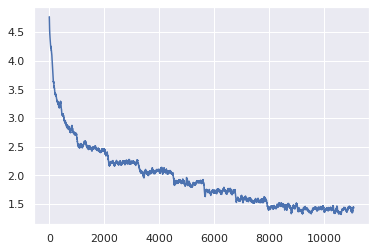

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

# Manual Testing

In [ ]:
test_sentence = test_dataset[0]['translation']['en']
print('Raw input text:', test_sentence)

input_ids = encode_input_str(
    text = test_sentence,
    target_lang = 'ja',
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: It has been confirmed that eight thoroughbred race horses at Randwick Racecourse in Sydney have been infected with equine influenza.
Truncated input text: <jp> It has been confirmed that eight thoroughbred race horses at Randwick Racecourse</s>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3)
# print(output_tokens)
for token_set in output_tokens:
  print(tokenizer.decode(token_set, skip_special_tokens=True))

ランディウィック・レースコーストで8匹のトロピカル・レース・
ランディッキーのレース場で8匹のトロピカル・レース・ホッケーが
ランディック・レースコーストで8匹のトロピカル・レース・ホッ


In [ ]:
#@title Slick Blue Translate
input_text = 'A surfboarder ran into a shark' #@param {type:"string"}
output_language = 'ja' #@param ["en", "ja", "zh"]

input_ids = encode_input_str(
    text = input_text,
    target_lang = output_language,
    tokenizer = tokenizer,
    seq_len = model.config.max_length,
    lang_token_map = LANG_TOKEN_MAPPING)
input_ids = input_ids.unsqueeze(0).cuda()

output_tokens = model.generate(input_ids, num_beams=20, length_penalty=0.2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

A surfboarder ran into a shark  ->  水泳選手はサメの群れの中にいた。
